# Gradient (Descent) of Cost (MSE) on Batch of Data

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
xs = torch.linspace(0, 7, steps=8)
xs

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

In [3]:
ys = -0.5*xs + 2 + torch.normal(mean=torch.zeros(8), std=0.2)
ys

tensor([ 1.7935,  1.2860,  1.2272,  0.5748,  0.2169, -0.4166, -0.8881, -1.5801])

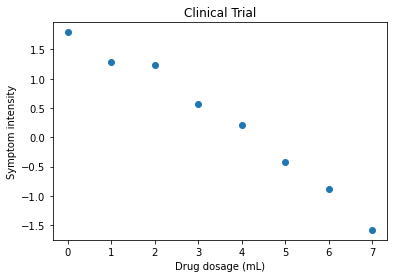

In [4]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Symptom intensity")
ax.scatter(xs, ys)
plt.show()

The slope of a line is given by $y = mx + b$:

In [5]:
def regression(my_x, my_m, my_b):
  return my_m*my_x + my_b

Initialize $m$ and $b$ with the same "random" near-zero values

In [6]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

In [7]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

### Step 1: Forward pass

In [8]:
yhats = regression(xs, m , b)
yhats

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

### Step 2: Compare $\hat{y}$ with true $y$ to calculate cost $C$ (MSE)

$C(MSE) = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $

In [9]:
def mse(my_yhat, my_y): 
    mse_cost = (1/len(my_y)) * (torch.sum((my_yhat - my_y)**2))
    return mse_cost

In [10]:
C = mse(yhats, ys)
C

tensor(18.7677, grad_fn=<MulBackward0>)

### Step 3: Use autodiff to calculate gradient of $C$ (MSE) wrt. parameters $m$ and $b$

In [11]:
C.backward()

In [12]:
m.grad

tensor([35.2350])

In [13]:
m.grad

tensor([35.2350])


$ \frac{\partial C}{\partial m} = \frac{2}{n} \sum (\hat{y}_i - y_i) \cdot x_i $

In [14]:
(2/len(ys)) * torch.sum((yhats-ys) * xs) # confirm result of m.grad

tensor(35.2350, grad_fn=<MulBackward0>)

In [15]:
b.grad

tensor([5.9466])

$ \frac{\partial C}{\partial b} = \frac{2}{n} \sum (\hat{y}_i - y_i) $

In [16]:
(2/len(ys)) * torch.sum((yhats-ys)) # confirm result of b.grad

tensor(5.9466, grad_fn=<MulBackward0>)

The gradient of cost, which is symbolized $\nabla C$ (pronounced "nabla C"), is a vector of all the partial derivatives of $C$ with respect to each of the individual model parameters:

$\nabla C = \nabla_p C = \left[ \frac{\partial{C}}{\partial{p_1}}, \frac{\partial{C}}{\partial{p_2}}, \cdots, \frac{\partial{C}}{\partial{p_n}} \right]^T $

In this case, there are only two parameters, $b$ and $m$:

$\nabla C = \left[ \frac{\partial{C}}{\partial{b}}, \frac{\partial{C}}{\partial{m}} \right]^T $

In [17]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T # not needed right now, but for illustration
gradient

tensor([[ 5.9466],
        [35.2350]])

In [18]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):
    
    title = 'Cost = {}'.format('%.3g' % my_C.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % my_m.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % my_b.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % my_m.item())        
        ylabel = 'b = {}'.format('%.3g' % my_b.item())
    
    fig, ax = plt.subplots()
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(my_x, my_y, zorder=3)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b)
    y_max = regression(x_max, my_m, my_b)

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='orange')

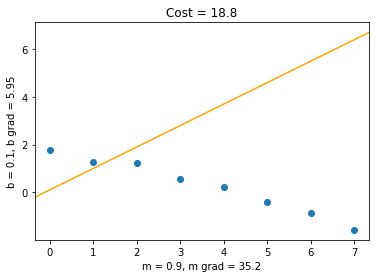

In [19]:
labeled_regression_plot(xs, ys, m, b, C)

### Step 4: Gradient descent

$\frac{\partial C}{\partial m} = 35.9$ indicates that an increase in $m$ corresponds to a large increase in $C$.

$\frac{\partial C}{\partial b} = 5.94$ indicates that an increase in $b$ corresponds to an increase in $C$, though much less so than $m$.

In the first round of training, to reduce cost $C$, the slope of the regression line, $m$, will be decreased. There will also be a relatively small decrease in the $y$-intercept of the line, $b$.

In [20]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [21]:
optimizer.step()

In [22]:
C = mse(regression(xs, m , b), ys)

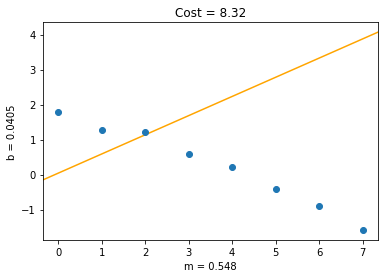

In [23]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False) # C.backward() not executed here for grad of C

$C$ was reduced significantly, as was $m$, whilst $b$ was adjusted just slightly (corresponding to the smaller gradient of $C$ wrt. $b$).

### Iteratively minimise cost (MSE) toward zero

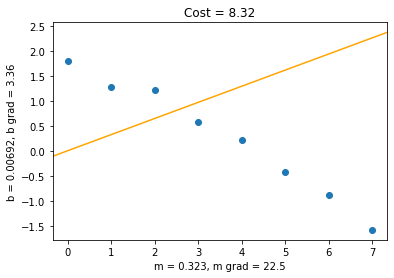

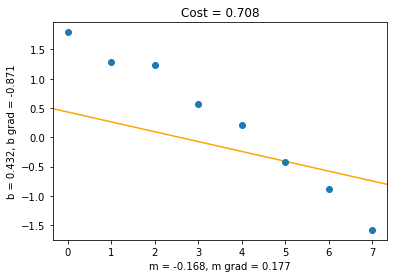

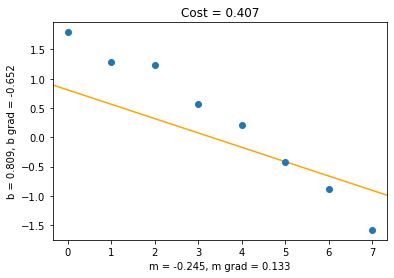

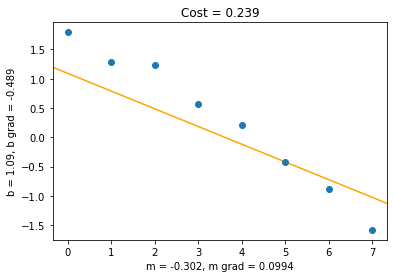

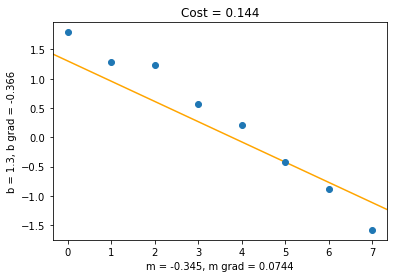

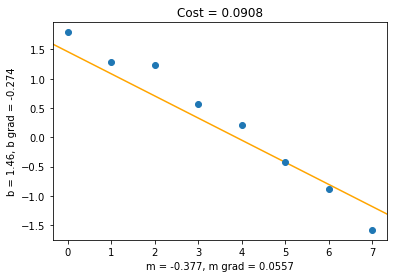

In [24]:
epochs = 300 # added to previous round

for epoch in range(epochs):

  optimizer.zero_grad() # reset gradients to zero, else they accumulate

  # Step 1: Forward pass
  yhats = regression(xs, m, b)

  # Step 2: Compute cost
  C = mse(yhats, ys)

  # Step 3: Autodiff for grad of C wrt. to m and b
  C.backward()

  # Step 4: Gradient descent i.e. adjust m and b
  optimizer.step()

  # Plot result of training every 10th round
  if (epoch % 50) == 0:
    labeled_regression_plot(xs, ys, m, b, C)

In later rounds of training, after the model's slope $m$ has become closer to the slope represented by the data, $\frac{\partial C}{\partial b}$ becomes negative, indicating an inverse relationship between $b$ and $C$. Meanwhile, $\frac{\partial C}{\partial m}$ remains positive.

This combination directs gradient descent to simultaneously adjust the $y$-intercept $b$ upwards and the slope $m$ downwards in order to reduce cost $C$ and, ultimately, fit the regression line snugly to the data.